In [42]:
import pandas as pd
import datetime
import time
import ccxt
import seaborn as sns
import matplotlib.pyplot as plt
from pydantic import BaseModel
from typing import Dict, Any, List
import matplotlib.dates as mdates

In [43]:
EXCHANGES: Dict[str, Dict[str, Any]] = {
    "bitget": {
        "exchange_object": ccxt.bitget,
        "tax_record_limit": 500,
        "usdt_futures": {
            "product_type": 'USDT-FUTURES',
            "records_column_names": ["id", "symbol", "marginCoin", "futureTaxType", "amount", "fee", "ts"],
            "tax_type": "futureTaxType",
            "trading_types": ["open_long", "close_long", "open_short", "close_short", "contract_margin_settle_fee"],
        },
    },
}

def convert_date_to_timestamp(date_str: str) -> int:
    return int(datetime.datetime.strptime(date_str, "%Y-%m-%d").timestamp() * 1000)

def convert_timestamp_to_date(timestamp: int) -> str:
    return datetime.datetime.fromtimestamp(int(timestamp) / 1000).strftime("%Y-%m-%d %H:%M:%S")


class RecordsProcessor:
    def __init__(self, client, config: Dict[str, Any]):
        self.client = client
        self.product_type = config["product_type"]
        self.record_limit = config["record_limit"]
        self.interval_ms = config["interval_ms"]
        self.column_names = config["records_column_names"]
        self.tax_type = config["tax_type"]
        self.trading_types = config["trading_types"]
        self.records_raw = []
        self.records_raw_df = None
        self.records = None
        self.trading_records = None
        self.extra_records = None
        self.pairs = None
        self.trades = None

    def fetch_and_process_records(self, start_date: str, sleep: bool = False):
        self._fetch_records(start_date, sleep)
        self._convert_records()
        self._set_pairs()
        self._complement_records()
        self._create_trades_table()

    def _fetch_records(self, start_date: str, sleep: bool = False):
        start_timestamp = convert_date_to_timestamp(start_date)
        current_timestamp = int(time.time() * 1000)
        while start_timestamp < current_timestamp:
            if sleep:
                time.sleep(1)
            end_timestamp = start_timestamp + self.interval_ms
            self.records_raw.extend(self._fetch_records_within_interval(start_timestamp, end_timestamp, current_timestamp))
            start_timestamp = end_timestamp

    def _fetch_records_within_interval(self, start_timestamp: int, end_timestamp: int, current_timestamp: int) -> List[Dict[str, Any]]:
        total = []
        while start_timestamp < current_timestamp:
            response = self.client.privateTaxGetV2TaxFutureRecord({
                "productType": self.product_type,
                "startTime": start_timestamp,
                "endTime": min(end_timestamp, current_timestamp),
            })
            current_records = response["data"]
            start_date = convert_timestamp_to_date(start_timestamp)
            end_date = convert_timestamp_to_date(min(end_timestamp, current_timestamp))
            print(f"Fetching data from {start_date} to {end_date}, found {len(current_records)} entries")
            total.extend(current_records)

            if len(current_records) < self.record_limit:
                break
            else:
                last_id = current_records[-1]["id"]
                total.extend(self._fetch_additional_records(start_timestamp, end_timestamp, current_timestamp, last_id))

        return total

    def _fetch_additional_records(self, start_timestamp: int, end_timestamp: int, current_timestamp: int, last_id: str) -> List[Dict[str, Any]]:
        additional_records = []
        while True:
            response = self.client.privateTaxGetV2TaxFutureRecord({
                "productType": self.product_type,
                "startTime": start_timestamp,
                "endTime": min(end_timestamp, current_timestamp),
                "idLessThan": last_id,
            })
            more_records = response["data"]
            print(f"Fetching additional data from {start_timestamp} to {min(end_timestamp, current_timestamp)}, found {len(more_records)} entries")

            additional_records.extend(more_records)

            if len(more_records) < self.record_limit:
                break
            else:
                last_id = more_records[-1]["id"]

        return additional_records

    def _convert_records(self):
        self.records = pd.DataFrame(self.records_raw, columns=self.column_names)
        self.records_raw_df = self.records.copy()
        self.records["date"] = pd.to_datetime(self.records["ts"].apply(lambda x: convert_timestamp_to_date(x)))
        self.records.set_index("date", inplace=True)

    def _set_pairs(self):
        if "symbol" in self.records.columns:
            self.pairs = self.records["symbol"].unique().tolist()
        elif "coin" in self.records.columns:
            self.pairs = self.records["coin"].unique().tolist()

    def _complement_records(self):
        self.records.loc[:, "amount"] = self.records["amount"].astype(float)
        self.records.loc[:, "fee"] = self.records["fee"].astype(float)
        self.records.loc[:, "pnl"] = self.records.apply(lambda row: row["fee"] + row["amount"] if row[self.tax_type] in ["open_long", "close_long", "open_short", "close_short"] else 0, axis=1)
        self.records.loc[:, "funding_fee"] = self.records.apply(lambda row: row["amount"] if row[self.tax_type] == "contract_margin_settle_fee" else 0, axis=1)
        self.records.loc[:, "transfer"] = self.records.apply(lambda row: row["amount"] if row[self.tax_type] in ["trans_from_exchange", "trans_to_exchange"] else 0, axis=1)
        self.records.loc[:, "cumulativePnl"] = (self.records["pnl"] + self.records["funding_fee"]).cumsum()
        self.records.loc[:, "cumulativeCapital"] = (self.records["pnl"] + self.records["funding_fee"] + self.records["transfer"]).cumsum()
        self.records = self.records.reindex(columns=[self.tax_type, 'symbol', 'amount', 'fee', 'pnl', 'cumulativePnl', 'cumulativeCapital', 'transfer', "funding_fee", 'id', 'ts'])
        self.trading_records = self.records[self.records[self.tax_type].isin(self.trading_types)]
        self.extra_records = self.records[~self.records[self.tax_type].isin(self.trading_types)]

    def _create_trades_table(self):
        close_trades = self.trading_records[self.trading_records[self.tax_type].isin(["close_long", "close_short"])]
        close_trades = close_trades.copy()
        close_trades.loc[:, "type"] = close_trades[self.tax_type].apply(lambda x: "long" if x == "close_long" else ("short" if x == "close_short" else "other"))
        trades = close_trades.reset_index()[["date", "symbol", "type", "pnl"]]
        trades.reset_index(drop=True, inplace=True)
        self.trades = trades

class AnalysisResult(BaseModel):
    total_trades: int = 0
    capital: float = 0.0
    pnl: float = 0.0
    win_rate: float = 0.0
    fees: float = 0.0
    funding_fees: float = 0.0
    first_date: str = None
    last_date: str = None
    longs_pnl: float = 0.0
    shorts_pnl: float = 0.0
    longs_win_rate: float = 0.0
    shorts_win_rate: float = 0.0
    longs_trades_count: int = 0
    shorts_trades_count: int = 0


class RecordsAnalyzer:
    def __init__(self, records: pd.DataFrame, tax_type: str):
        self.records = records
        self.tax_type = tax_type
        self.results = {}

    def analyse_global(self):
        analysis = self._analyse_records(self.records)
        self.results["global"] = analysis.model_dump()

    def analyse_by_pair(self, pairs: List[str]):
        for pair in pairs:
            pair_records = self.records[self.records["symbol"] == pair]
            analysis = self._analyse_records(pair_records)
            self.results[pair] = analysis.model_dump()

    def _analyse_records(self, record: pd.DataFrame) -> AnalysisResult:
        if record.empty:
            return AnalysisResult()

        total_trades = record.loc[record[self.tax_type].isin(["close_long", "close_short"])].shape[0]
        capital = record["cumulativeCapital"].iloc[-1]
        pnl = record["pnl"].sum()
        win_rate = (record.loc[record["pnl"] > 0].shape[0] / total_trades) * 100 if total_trades > 0 else 0
        fees = record["fee"].sum()
        funding_fees = record["funding_fee"].sum()
        first_date = self._convert_timestamp_to_date(record["ts"].min())
        last_date = self._convert_timestamp_to_date(record["ts"].max())

        long_trades = record.loc[record[self.tax_type] == "close_long"]
        longs_trades_count = long_trades.shape[0]
        winning_long_trades = long_trades.loc[long_trades["pnl"] > 0].shape[0]
        longs_win_rate = (winning_long_trades / longs_trades_count) * 100 if longs_trades_count > 0 else 0
        longs_pnl = record.loc[record[self.tax_type].isin(["open_long", "close_long"]), "pnl"].sum()

        short_trades = record.loc[record[self.tax_type] == "close_short"]
        shorts_trades_count = short_trades.shape[0]
        winning_short_trades = short_trades.loc[short_trades["pnl"] > 0].shape[0]
        shorts_win_rate = (winning_short_trades / shorts_trades_count) * 100 if shorts_trades_count > 0 else 0
        shorts_pnl = record.loc[record[self.tax_type].isin(["open_short", "close_short"]), "pnl"].sum()

        return AnalysisResult(
            total_trades=total_trades,
            capital=capital,
            pnl=pnl,
            win_rate=win_rate,
            fees=fees,
            funding_fees=funding_fees,
            first_date=first_date,
            last_date=last_date,
            longs_pnl=longs_pnl,
            shorts_pnl=shorts_pnl,
            longs_win_rate=longs_win_rate,
            shorts_win_rate=shorts_win_rate,
            longs_trades_count=longs_trades_count,
            shorts_trades_count=shorts_trades_count,
        )

    @staticmethod
    def _convert_timestamp_to_date(timestamp: int) -> str:
        return datetime.datetime.fromtimestamp(int(timestamp) / 1000).strftime("%Y-%m-%d %H:%M:%S")


class RecordsManager:
    def __init__(self, api_setup: Dict[str, Any], exchange: str, market: str, filename: str = None):
        self._client = EXCHANGES[exchange]["exchange_object"](api_setup)
        self._config = {
            "record_limit": EXCHANGES[exchange]["tax_record_limit"],
            "product_type": EXCHANGES[exchange][market]["product_type"],
            "records_column_names": EXCHANGES[exchange][market]["records_column_names"],
            "tax_type": EXCHANGES[exchange][market]["tax_type"],
            "trading_types": EXCHANGES[exchange][market]["trading_types"],
            "interval_ms": 30 * 24 * 60 * 60 * 1000
        }
        self._filename = filename
        self.results = {}
        self.records = None
        self.records_raw_df = None
        self.trading_records = None
        self.extra_records = None
        self.pairs = None
        self.trades = None

    def process(self, start_date: str, sleep: bool = False):
        processor = RecordsProcessor(self._client, self._config)
        processor.fetch_and_process_records(start_date, sleep)
        self.records = processor.records
        self.records_raw_df = processor.records_raw_df
        self.trading_records = processor.trading_records
        self.extra_records = processor.extra_records
        self.pairs = processor.pairs
        self.trades = processor.trades
        if self._filename:
            self._save_records_to_csv(self.records)

        analyser = RecordsAnalyzer(self.records, self._config["tax_type"])
        analyser.analyse_global()
        analyser.analyse_by_pair(self.pairs)
        self.results = analyser.results

    def print_global_analysis(self):
        global_analysis = self.results.get("global", {})
        print("\n ** Global Analysis ** \n")
        print(f"Dates: {global_analysis.get('first_date')} -> {global_analysis.get('last_date')}")
        print(f"Capital: {round(global_analysis.get('capital'),2)}")
        print(f"Trades: {global_analysis.get('total_trades')}")
        print(f"Win Rate: {round(global_analysis.get('win_rate', 0), 2)} %")
        print(f"PnL: {round(global_analysis.get('pnl', 0), 2)} $")
        print(f"Fees: {round(global_analysis.get('fees', 0), 2)} $")
        print(f"Funding Fees: {round(global_analysis.get('funding_fees', 0), 2)} $\n ")

        print("Longs:")
        print(f"  - Trades: {global_analysis.get('longs_trades_count')}")
        print(f"  - PnL: {round(global_analysis.get('longs_pnl', 0), 2)} $")
        print(f"  - Win Rate: {round(global_analysis.get('longs_win_rate', 0), 2)} %")

        print("Shorts:")
        print(f"  - Trades: {global_analysis.get('shorts_trades_count')}")
        print(f"  - PnL: {round(global_analysis.get('shorts_pnl', 0), 2)} $")
        print(f"  - Win Rate: {round(global_analysis.get('shorts_win_rate', 0), 2)} %")

    def _save_records_to_csv(self, records: pd.DataFrame):
        records.to_csv(self._filename + ".csv", index=True)

    def plot_over_time(self, metric: str, show_transfers=True):
        plt.figure(figsize=(8, 4))
        if metric == "PnL":
            plt.plot(self.records.index, self.records["cumulativePnl"], label="Cumulative P&L", color="blue")
            plt.ylabel("Cumulative P&L ($)", fontsize=14)
        elif metric == "Capital":
            plt.plot(self.records.index, self.records["cumulativeCapital"], label="Cumulative Capital", color="green")
            plt.ylabel("Cumulative Capital ($)", fontsize=14)
        else:
            raise ValueError("Unsupported metric for plot_over_time")

        plt.title(f"{metric} Over Time", fontsize=16)
        plt.grid(True, linestyle=':', color='gray', alpha=0.5)
        plt.xticks(rotation=45, fontsize=10)
        plt.xlabel('')
        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())

        if show_transfers:
            transfer_dates = self.records[self.records["transfer"] != 0].index
            for i, date in enumerate(transfer_dates):
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=0.8, label='Transfers' if i == 0 else "")

        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_per_pair(self, metric: str, include_funding_fees=True):
        if metric not in ["PnL", "Funding Fees", "Win Rate", "Trades"]:
            raise ValueError("Unsupported metric for plot_per_pair")

        plot_data = []
        for pair, data in self.results.items():
            if pair == "global":
                continue
            if metric == "PnL":
                pnl = data["pnl"] + (data["funding_fees"] if include_funding_fees else 0)
                plot_data.append((pair, pnl))
                ylabel = "P&L ($)"
                title = "P&L per Pair (Including Funding Fees)" if include_funding_fees else "P&L per Pair (Without Funding Fees)"
            elif metric == "Funding Fees":
                plot_data.append((pair, data["funding_fees"]))
                ylabel = "Funding Fees ($)"
                title = "Funding Fees per Pair"
            elif metric == "Win Rate":
                plot_data.append((pair, data["win_rate"]))
                ylabel = "Win Rate (%)"
                title = "Win Rate per Pair"
            elif metric == "Trades":
                plot_data.append((pair, data["total_trades"]))
                ylabel = "Number of Trades"
                title = "Number of Trades per Pair"

        plot_df = pd.DataFrame(plot_data, columns=["symbol", metric])
        plot_df = plot_df.sort_values(by="symbol")

        norm = plt.Normalize(plot_df[metric].min(), plot_df[metric].max())
        sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
        sm.set_array([])

        plt.figure(figsize=(8, 5))
        sns.barplot(x="symbol", y=metric, data=plot_df, palette="RdYlGn", hue=metric, dodge=False, legend=False)
        plt.title(title, fontsize=15)
        plt.ylabel(ylabel, fontsize=13)
        plt.xticks(rotation=45, fontsize=9)
        plt.yticks(fontsize=10)
        plt.xlabel('')
        plt.grid(True, linestyle=':', color='gray', alpha=0.5)
        plt.tight_layout()
        plt.show()

    def plot_per_trade_type(self, metric: str, results="global"):
        data = self.results[results]
        if metric == "PnL":
            plot_data = {
                "Trade Type": ["Longs", "Shorts"],
                "Value": [data["longs_pnl"], data["shorts_pnl"]]
            }
            ylabel = "P&L ($)"
        elif metric == "Trades":
            plot_data = {
                "Trade Type": ["Longs", "Shorts"],
                "Value": [data["longs_trades_count"], data["shorts_trades_count"]]
            }
            ylabel = "Number of Trades"
        elif metric == "Win Rate":
            plot_data = {
                "Trade Type": ["Longs", "Shorts"],
                "Value": [data["longs_win_rate"], data["shorts_win_rate"]]
            }
            ylabel = "Win Rate (%)"
        else:
            raise ValueError("Unsupported metric for plot_per_trade_type")

        plt.figure(figsize=(5, 3))
        sns.barplot(x="Trade Type", y="Value", data=pd.DataFrame(plot_data), palette="RdYlGn", hue="Value", dodge=False, legend=False)
        plt.title(f"{metric} per Trade Type ({results.capitalize()})", fontsize=16)
        plt.ylabel(ylabel, fontsize=13)
        plt.xticks(rotation=0, fontsize=13)
        plt.xlabel('')
        plt.grid(True, linestyle=':', color='gray', alpha=0.3)
        plt.tight_layout()
        plt.show()


In [44]:
api_setup = {
    "apiKey": "",
    "secret": "",
    "password": "",
    "options": {
        "defaultType": "swap",
    },
}
records_manager = RecordsManager(api_setup, "bitget", "usdt_futures")

start_date = "2024-01-01"
records_manager.process(start_date, sleep=True)

Fetching data from 2024-01-01 00:00:00 to 2024-01-31 00:00:00, found 0 entries
Fetching data from 2024-01-31 00:00:00 to 2024-03-01 00:00:00, found 0 entries
Fetching data from 2024-03-01 00:00:00 to 2024-03-31 00:00:00, found 0 entries
Fetching data from 2024-03-31 00:00:00 to 2024-04-30 01:00:00, found 263 entries
Fetching data from 2024-04-30 01:00:00 to 2024-05-30 01:00:00, found 46 entries
Fetching data from 2024-05-30 01:00:00 to 2024-06-29 01:00:00, found 200 entries
Fetching data from 2024-06-29 01:00:00 to 2024-07-29 01:00:00, found 76 entries
Fetching data from 2024-07-29 01:00:00 to 2024-08-28 01:00:00, found 227 entries
Fetching data from 2024-08-28 01:00:00 to 2024-09-27 01:00:00, found 27 entries
Fetching data from 2024-09-27 01:00:00 to 2024-10-10 16:28:55, found 22 entries


In [45]:
records_manager.print_global_analysis()


 ** Global Analysis ** 

Dates: 2024-04-07 18:01:57 -> 2024-10-02 00:01:23
Capital: 1078.19
Trades: 311
Win Rate: 73.95 %
PnL: 187.04 $
Fees: -8.05 $
Funding Fees: -0.15 $
 
Longs:
  - Trades: 196
  - PnL: 196.38 $
  - Win Rate: 87.24 %
Shorts:
  - Trades: 115
  - PnL: -9.34 $
  - Win Rate: 51.3 %


In [46]:
records_manager.records_raw_df

,id,symbol,marginCoin,futureTaxType,amount,fee,ts
0,1160898608589578243,,USDT,trans_from_exchange,800,0,1712505717417
1,1161168487007789059,LDOUSDT,USDT,open_short,0,-0.0033775906,1712570061446
2,1161232239694585897,LDOUSDT,USDT,close_short,-0.12663,-0.0033991177,1712585261271
3,1162732181135171611,ACHUSDT,USDT,open_long,0,-0.00339689784,1712942875178
4,1162732291164348417,FETUSDT,USDT,open_long,0,-0.003032664,1712942901411
...,...,...,...,...,...,...,...
856,1225063873728094232,FLOKIUSDT,USDT,close_long,0.09069555,-0.001124253044,1727803908759
857,1225063873728094259,FLOKIUSDT,USDT,close_long,0.07251162,-0.000910366992,1727803908759
858,1225063873732288538,FLOKIUSDT,USDT,close_long,1.69917543,-0.021332763288,1727803908760
859,1225064540488212498,PENDLEUSDT,USDT,close_long,0.3495,-0.00625644,1727804067727


In [47]:
records_manager.trades

,date,symbol,type,pnl
0,2024-04-08 16:07:41,LDOUSDT,short,-0.130029
1,2024-04-12 23:10:42,ICPUSDT,long,-0.108744
2,2024-04-13 00:00:51,ACHUSDT,long,0.320323
3,2024-04-13 00:00:53,ADAUSDT,long,-0.021681
4,2024-04-13 00:00:55,APEUSDT,long,-2.234996
...,...,...,...,...
306,2024-10-01 19:31:48,FLOKIUSDT,long,0.089571
307,2024-10-01 19:31:48,FLOKIUSDT,long,0.071601
308,2024-10-01 19:31:48,FLOKIUSDT,long,1.677843
309,2024-10-01 19:34:27,PENDLEUSDT,long,0.343244


In [48]:
records_manager.extra_records

,futureTaxType,symbol,amount,fee,pnl,cumulativePnl,cumulativeCapital,transfer,funding_fee,id,ts
date,,,,,,,,,,,
2024-04-07 18:01:57,trans_from_exchange,,800.0,0.0,0.0,0.000000,800.000000,800.00000,0.0,1160898608589578243,1712505717417
2024-04-14 20:09:44,trans_from_exchange,,165.0,0.0,0.0,39.031310,1004.031310,165.00000,0.0,1163467480513519618,1713118184211
2024-05-17 15:47:19,trans_to_exchange,,-200.0,0.0,0.0,57.945437,822.945437,-200.00000,0.0,1175360243823681543,1715953639941
2024-05-17 20:57:05,trans_from_exchange,,500.0,0.0,0.0,57.945437,1322.945437,500.00000,0.0,1175438197161336834,1715972225465
2024-05-17 20:57:57,trans_to_exchange,,-300.0,0.0,0.0,57.945437,1022.945437,-300.00000,0.0,1175438415055429634,1715972277415
2024-06-28 11:38:55,trans_to_exchange,,-73.70009,0.0,0.0,108.700090,1000.000000,-73.70009,0.0,1190518019289915394,1719567535230


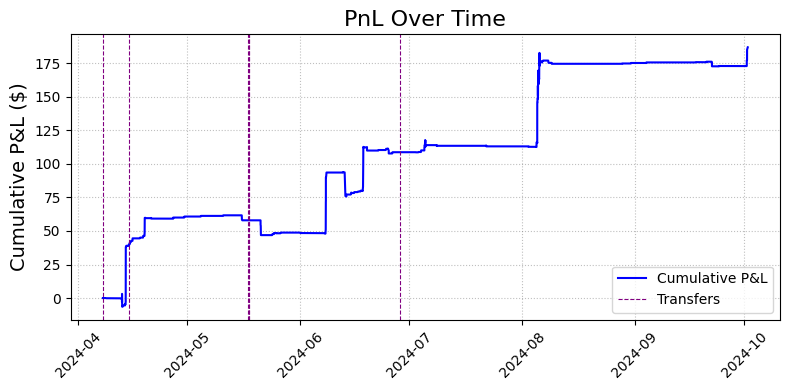

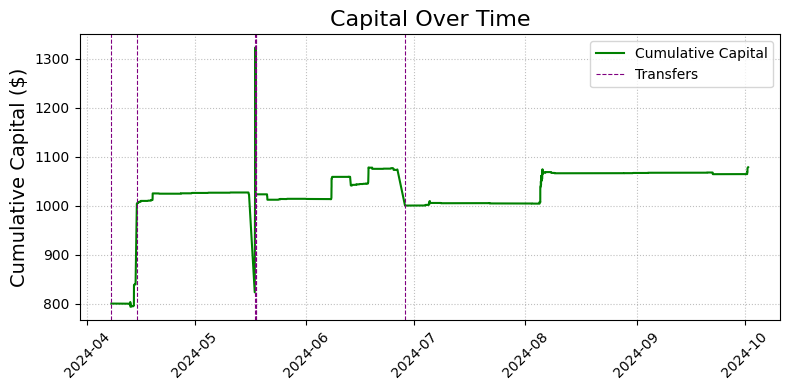

In [49]:
records_manager.plot_over_time(metric="PnL", show_transfers=True)
records_manager.plot_over_time(metric="Capital", show_transfers=True)

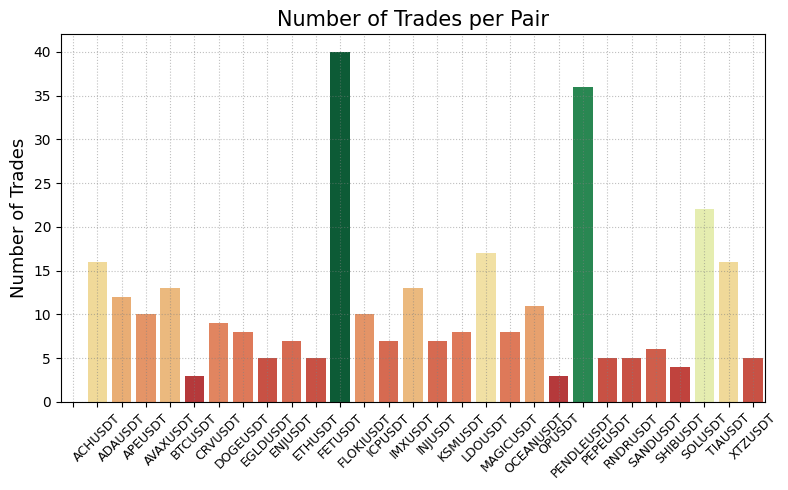

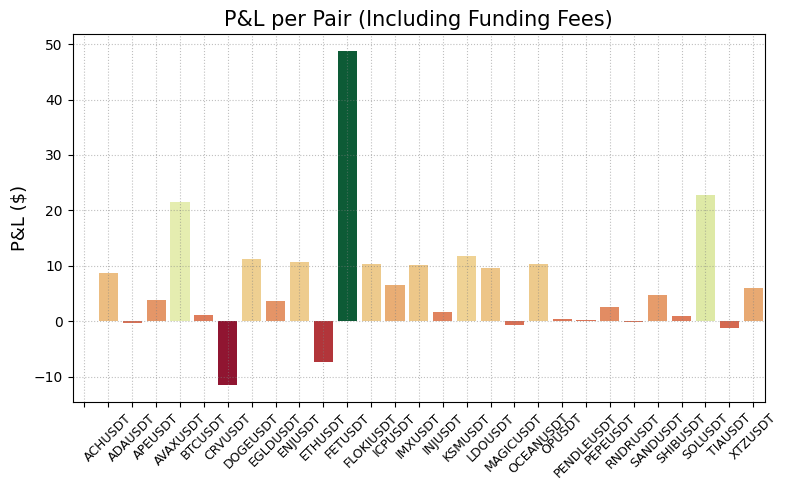

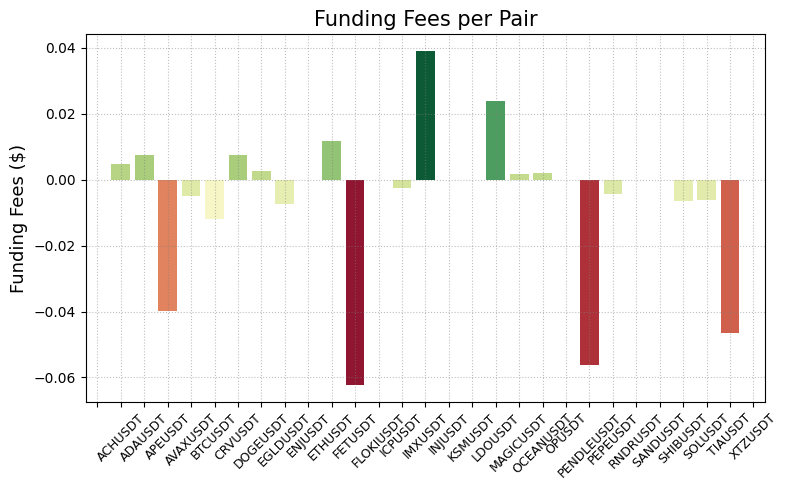

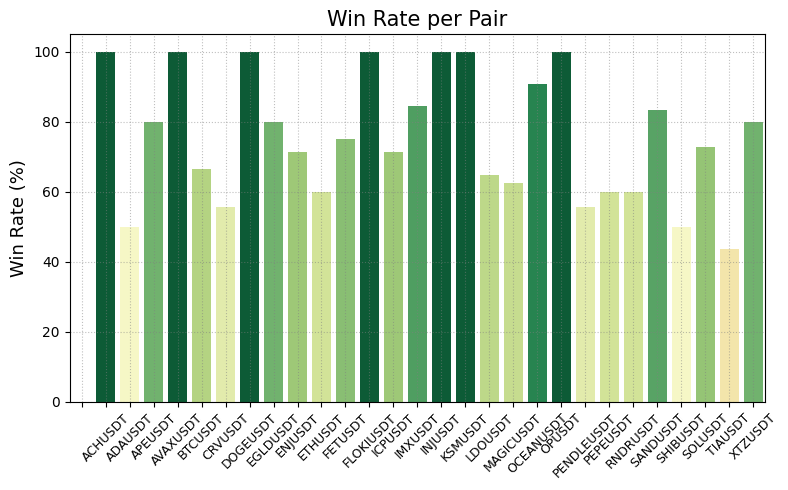

In [50]:
records_manager.plot_per_pair(metric="Trades")
records_manager.plot_per_pair(metric="PnL", include_funding_fees=True)
records_manager.plot_per_pair(metric="Funding Fees")
records_manager.plot_per_pair(metric="Win Rate")

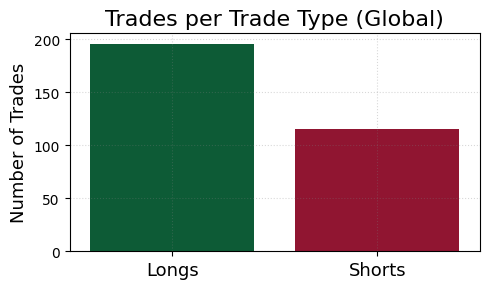

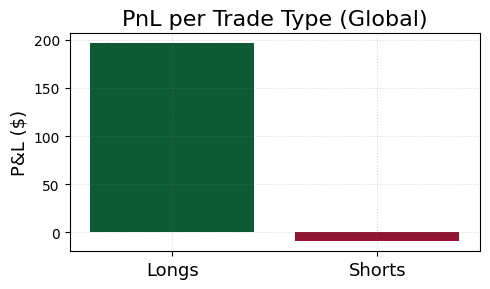

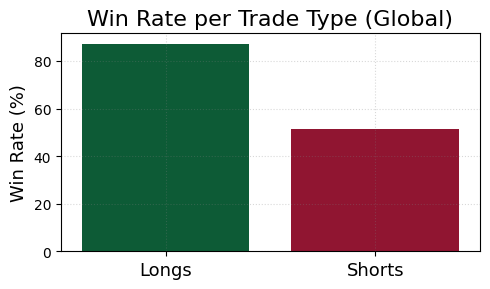

In [51]:
records_manager.plot_per_trade_type(metric="Trades", results="global")
records_manager.plot_per_trade_type(metric="PnL", results="global")
records_manager.plot_per_trade_type(metric="Win Rate", results="global")

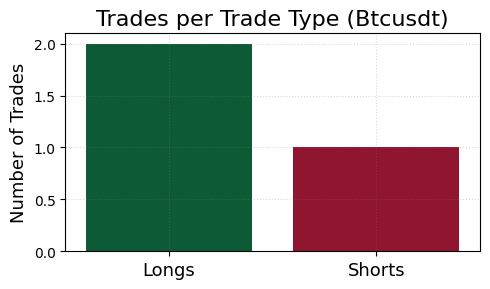

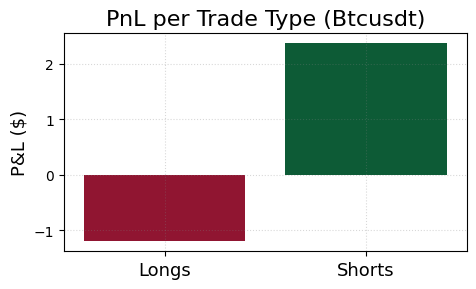

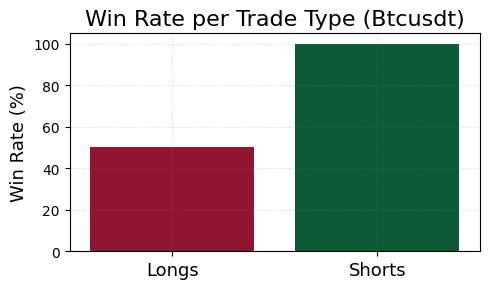

In [52]:
pair="BTCUSDT"
records_manager.plot_per_trade_type(metric="Trades", results=pair)
records_manager.plot_per_trade_type(metric="PnL", results=pair)
records_manager.plot_per_trade_type(metric="Win Rate", results=pair)